#**Tutorial for the Columbia HAZard (CHAZ) model** - Downscaling

---
The beta version of CHAZ can be downloaded from GitHub https://github.com/cl3225/CHAZ. This tutorial converts the scripts into JupyterNB for better understanding of each of the components.

FLAG NOTES:

- `TODO` flag marks an area I'm confused about, have an update for, or a question about 
- `TODO QUESTION` flag for (hopefully) simple questions I have 


In [1]:
# !pip install netCDF4
# !pip install cartopy

In [2]:
# Import necessary libraries
import numpy as np
from numpy import nanmean

import pandas as pd
import xarray as xr
import os
import matplotlib.pyplot as plt
import random
from scipy.io import netcdf_file
from scipy.io import loadmat
from scipy import stats

import calendar
from datetime import datetime,timedelta
import time
import sys
import dask.array as da
import numpy.ma as ma
import gc
from netCDF4 import Dataset,date2num,num2date
import netCDF4 as nc
from dask.diagnostics import ProgressBar

## numba JIT compilation
import numba

import subprocess
import pickle
import copy
#import random don't need this twice

import pooch

## profiling code to look for efficiency gains
import cProfile 

from tqdm.notebook import tqdm  



Create a random number generator from a set seed, for code testing and reproducibility. 

In [3]:
## adding random number generator with set seed to allow comparisons and reproducibility
## set seed = None to use computer chaos

seed = 42
rng = np.random.default_rng(seed=seed)

In [4]:
rng

Generator(PCG64) at 0x30568AC00

In [5]:
## added path_data to function call
def get_landmask(path_data):
    """
    This function reads landmask.nc. 
    read 0.25degree landmask.nc
    output:
        lon: longitude, 1D
        lat: latitude, 1D
        landmask: 2D

    """
    fopen = pooch.retrieve(url=f"{path_data}/landmask.nc",  known_hash=None)
    f = netcdf_file(fopen)
    lon = f.variables['lon'][:]
    lat = f.variables['lat'][:]
    landmask = f.variables['landmask'][:,:]
    f.close() ## this is not closing, see warning in [4]

    return lon, lat, landmask


## Step 0: Model basic settings

In [6]:
path_data = 'doi:10.5281/zenodo.11631930' # public data available at https://zenodo.org/records/11628647
yearTC = 2017

# Use class to define the global variables:
class gv():
    ### Experiment settings
    Model = 'ERA5'
    ENS = 'r1i1p1f1'
    TCGIinput = 'TCGI_CRH_PI'   # or "TCGI_SD_RI"
    CHAZ_ENS = 1                # Number of track realizations
    CHAZ_Int_ENS = 40           # Number of intensity realizations

    ### CHAZ parameters & other inputs path
    uBeta = -1.5
    vBeta = 2.0
    survivalrate = 0.78
    seedN = 1000                # annual seeding rate for random seeding
    obpath = 'bt_global_predictors.nc'

    llon, llat, lldmask = get_landmask(path_data)

    ldmask = lldmask[-12::-24,::24]
    lldmask = lldmask[::-1,:]

/var/folders/72/gq_qh34d21xgnsw2_5sf25rh0000gn/T/ipykernel_88303/2435941636.py:17: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  f.close() ## this is not closing, see warning in [4]


In [7]:
## alt land mask open
#ds = xr.open_dataset(pooch.retrieve(url=f"{path_data}/landmask.nc",  known_hash=None))
#ds.landmask.plot()

## Step 1: Tropical Cyclogenesis

This part seed TC disturbnaces based on the TCGI fields from pre-process code

In [8]:
def TCgiSeeding (gxlon, gxlat, gi, climInitLon, climInitLat, climInitDate, ratio, iy):
    '''
    This is a subroutine for calculating tropical cyclone genesis locations based on the
    genesis index (gi).
    
    ---- Parameters -------------------------------------- 
    gxlon : 2D array (nlat x nlon)
        mesh-grid of longitudes

    gxlat : 2D array (nlat x nlon)
        mesh-grid of latitudes
    
    gi : 3D array (month x nlat x nlon)
        Monthly tropical cyclone genisis index (gi). 
        "gi is tropical cyclone genesis index. We use nansum(gi) to for
        total number of seeds, and then randomly select location using gi
        as genesis probability."
            [higher values == more likely genisis?] TODO 
            [spatial probability distribution of cyclone 
            formation for each month.]
    
    climInitLon, climInitLat, climInitDate: lists
        Lists storing storing previous seeds information (lon, lat, and date)

    ratio: float
        how many more seeds we should give [create?], based on the survival rate
        [Scaling factor determining how many seeds to create relative to the total
        genesis index sum (accounts for survival rate).]

    iy: int
        target year for seeding

    ---- Returns ---------------------------------------- 
    None (modifies the climInitLon, climInitLat, and climInitDate lists in place)

    '''

    # loop through year (iy) by month 
    for im in range(12):
        xk, pk = np.arange(gi[im,:,:].size), gi[im,:,:].ravel()

        ## remove NaNs
        dummy = xk*pk
        xk, pk = xk[dummy==dummy], pk[dummy==dummy] # (dummy==dummy is False for NaNs)

        ## could rewrite to the following TODO
        ## not sure if it is faster (depends on size of array and how many NaNs)
        ## but it is definitely more clear 
        # mask = ~np.isnan(pk)           # where pk is NOT NaN
        # xk, pk = xk[mask], pk[mask]    # use mask indices to select where pk is NOT NaN

        ## Build discrete probability distribution (custm) using gi values as weights
        ## xk = possible grid indices, pk/pk.sum() = normalized probabilities
        custm = stats.rv_discrete(name='custm', values=(xk, pk/pk.sum()), seed = rng)

        ## randomly select grid point from custm 
        ## number of points selected [np.rint(pk.sum()*ratio)]
            # proportional to sum of gensis probability * ratio
        r = custm.rvs(size=np.int_(np.rint(pk.sum()*ratio)))

        ## map selected grid points into lon/lat coordinated
        iix = gxlon.ravel()[r.ravel()]
        iiy = gxlat.ravel()[r.ravel()]
        ## randomly select day in month to assign each seed 
        #iday = np.random.choice(np.arange(calendar.monthrange(iy,im+1)[1]), size=np.int_(np.rint(pk.sum()*ratio)), replace=True)

        ## update to use set rng
        iday = rng.choice(np.arange(calendar.monthrange(iy,im+1)[1]), size=np.int_(np.rint(pk.sum()*ratio)), replace=True)

        ## if there are days assigned a seed in the month:
        if iday.size>0:
            for id in range(iday.size):
                ## TODO QUESTION is this just random jitter? to avoid clustering? yes, but it is on purpose

                ## TODO combine this rng.uniform
                
                x1 = np.arange(iix[id]-1,iix[id]+1.01, 0.01)
                y1 = np.arange(iiy[id]-1,iiy[id]+1.01, 0.01)

                #xx = np.random.choice(x1,1)
                #yy = np.random.choice(y1,1)

                ## use set rng
                xx = rng.choice(x1, 1)
                yy = rng.choice(y1, 1)

                # append generated seed information to appropriate lists
                climInitDate.append(datetime(iy,im+1,iday[id]+1,0,0))
                climInitLon.append(xx)
                climInitLat.append(yy)

    return climInitLon, climInitLat, climInitDate

## probably should also add path_data as an input to this
#def getSeeding(iy, ratio):
def getSeeding(iy, ratio, path_data):
    climInitLon = []
    climInitLat = []
    climInitDate = []

    # Load the tropical cyclone genesis index (TCGI)
    tcgiFile = pooch.retrieve(url=f"{path_data}/{gv.TCGIinput}_{iy:04d}.nc", known_hash=None)
    ds = xr.open_dataset(tcgiFile)
    gi = ds.TCGI.values

    # Load longitude and latitude data
    xlon = ds['lon']
    xlat = ds['lat']

    # Create a meshgrid of longitude and latitude
    gxlon,gxlat = np.meshgrid(xlon,xlat)

    # Generate seeds based on the genesis index
    climInitLon,climInitLat,climInitDate = \
        TCgiSeeding (gxlon,gxlat,gi,climInitLon,climInitLat,climInitDate,ratio,iy)

    # Convert lists to numpy arrays and flatten them
    climInitDate = np.array(climInitDate).ravel()
    climInitLon = np.array(climInitLon).ravel()
    climInitLat = np.array(climInitLat).ravel()

    return climInitDate, climInitLon, climInitLat

In [9]:
ratio = 1 # ratio is a form of corretion in case the global TCGI number is too low
climInitDate, climInitLon, climInitLat = getSeeding(yearTC, ratio, path_data)

In [10]:
## check to confirm the random seed matches original
climInitDate[0:3]

array([datetime.datetime(2017, 1, 6, 0, 0),
       datetime.datetime(2017, 1, 29, 0, 0),
       datetime.datetime(2017, 1, 25, 0, 0)], dtype=object)

(-40.0, 40.0)

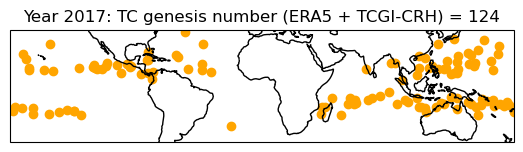

In [11]:
# Plot to see TC gensis locations:
import matplotlib.pyplot as plt
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature

MyFigsize,MyFontsize = (6.5,4),8
londis, latdis = 30, 15
lon1, lon2 = 10,350
lat1, lat2 = -60, 60
my_proj = ccrs.PlateCarree(central_longitude=180)
data_ccrs = ccrs.PlateCarree()

fig = plt.figure(figsize=MyFigsize)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(zorder=100)

## cmap is being ignored, defaulting to standard matplotlib blue. 
#ima = plt.scatter(climInitLon, climInitLat, transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r, zorder=0)

ima = plt.scatter(climInitLon, climInitLat, transform=ccrs.PlateCarree(), c = 'orange', zorder=0)

#ax.set_extent([lon1,lon2,lat1,lat2])
plt.title(f'Year {yearTC}: TC genesis number (ERA5 + TCGI-CRH) = {len(climInitLon)}')
plt.ylim(-40, 40)

Plot genesis days

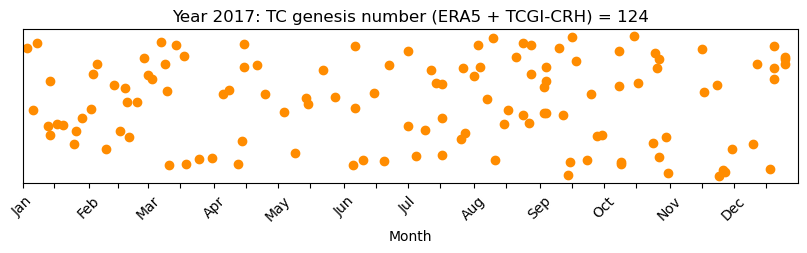

In [12]:
dates = pd.to_datetime(climInitDate)

# Extract day-of-year (1-365) for x-axis
days = dates.dayofyear

# Add a small random vertical offset so overlapping dots are visible
#y = np.random.rand(len(days)) * 0.1 + 0.5  # all dots roughly in the middle
y = rng.random(len(days)) * 0.1 + 0.5


# Plot
plt.figure(figsize=(10, 2))
plt.scatter(days, y, marker='o', color='darkorange')
plt.yticks([])  # hide y-axis

# Create x-axis ticks: start and middle of each month
tick_positions = []
tick_labels = []

for month in range(1, 13):
    start_day = datetime(2017, month, 1).timetuple().tm_yday
    mid_day = start_day + calendar.monthrange(2017, month)[1] // 2
    tick_positions.extend([start_day, mid_day])
    tick_labels.extend([calendar.month_abbr[month], ''])

plt.xticks(tick_positions, tick_labels, rotation=45)
plt.xlabel('Month')
#plt.title('TC Seed Dates in 2017')
plt.title(f'Year {yearTC}: TC genesis number (ERA5 + TCGI-CRH) = {len(climInitDate)}')

plt.xlim(1, 365)
plt.show()


## Step 2: Tracks
This part moves the initial seeds forward using a beta-advection model. It takes time.


Most of the code can be brought up to more up-to-date packages to increase stability and/or longevity. However, this does involve updating syntax:
- `np.nan` to `np.nan` because of this error: `AttributeError: np.NaN was removed in the NumPy 2.0 release. Use np.nan instead.`
- `np.float64` to `np.float64` because of this error: `AttributeError: np.float_ was removed in the NumPy 2.0 release. Use np.float64 instead.`



In [13]:
from functools import lru_cache

### helper functions to load datasets a single time and 
### hold in memory, rather than importing multiple times in loop 

@lru_cache(maxsize=None)
def load_I_MLR(year):
    fileName = pooch.retrieve(url=f"{path_data}/I_MLR_{year:04d}.nc", known_hash=None)
    print(f"Lazy loading from disk for year {year}")                       ## check that this only runs once 
    ds = xr.open_dataset(fileName)
    out = {k: ds[k].values for k in ['u250','v250','u850','v850']}
    lon, lat = ds['lon'].values, ds['lat'].values
    ds.close()
    return out, lon, lat

@lru_cache(maxsize=None)
def load_A(year, month):
    fname = pooch.retrieve(url=f"{path_data}/A_{year:04d}{month:02d}.nc", known_hash=None)
    ## check that this loads only when expected
    #print(f"\n    Loading A from disk for year {year} and month {month}")                       
    ds = xr.open_dataset(fname)
    A = ds['A'].load().values
    ds.close()
    return A

In [14]:
def func_first(x):
    '''
    This function returns the first non NA/Null value.
    '''

    ## first_valid_index() returns None if all values in series are None, so I think this if/else is reduplicative
    ## of just saying 
    ## From docs:  https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.first_valid_index.html
    ## Return index for first non-NA value or None, if no non-NA value is found.
    # return x.first_valid_index()
 
    # if x.first_valid_index() is None:
    #     return None
    # else:
    #     return x.first_valid_index()
    

    ## assuming there isn't a weird edge case, this is faster (from ~0.021 to 0.011 secons)
    ## ~2.7 seconds improvement per year
    return x.first_valid_index()

def func_last(x):
    '''
    This function returns the last non NA/Null value.
    '''

    # ## same as with first_valid_index, i think the if/else is unecessary 
    # # return x.last_valid_index()
    # if x.last_valid_index() is None:
    #     return None
    # else:
    #     return x.last_valid_index()
    
    ## assuming there isn't a weird edge case, this is faster

    return x.last_valid_index()

#@numba.jit(nopython=True)
def removeland(iS):
    '''
    This function removes land from the landmask.
    '''
    #print iS

    ## TODO: is np.int_ necessary?
    ## what dims are being kept? (these will slow down if looped)

    b = np.int_(iS.mean(keepdims=True))
    iT3 = -1

    if b<fstldmask.shape[1]:
        a = np.argwhere(fstldmask[:,b]==3).ravel()
        if a.size:
            if a.size>3:
                iT3 = a[0]+2
                fstlon[iT3:,b]=np.nan
                fstlat[iT3:,b]=np.nan
    return iT3


def calF(nday):
    '''
    This function finds the fourier function.
    nday: number of days
    '''
    ## VECTORIZED 
    dt = 1.0*60*60         # 1 hr in seconds
    T = np.float64(15)     # 15-day period of the fourier series
    N = 15                 # number of sine waves
    nt = np.arange(0, nday*60*60*24, dt)

    # Define iN and itt (shape/data holders)
    iN = np.arange(1, N+1, dtype = float)              # shape (N,)
    itt = np.arange(nt.size, dtype = float)            # shape (nt,)
    #X = np.random.uniform(0, 1, (N, 4))                # random phases for 4 columns

    # use random number generator with set seed
    X = rng.uniform(0, 1, (4, N)).T         ## transposed to match original shape 

    #  vectorized equation
    F = (np.sqrt(2.0 / np.sum(iN**-3)) *
            np.sum(
                (iN**(-3/2))[:, None, None] * 
                np.sin(2*np.pi * ((iN[:, None, None] * itt[None, :, None]) / (24*T) + X[:, None, :])),
                axis=0
            )
    )

    return F


def fillinNaN(var, neighbors):
    """
    Replace masked areas using interpolation.
    """

    ## TODO: harder to, but could be optimized

    for ii in range(var.shape[0]):
        a = var[ii, :, :]
        while np.any(a.mask):
            a_copy = a.copy()
            for hor_shift, vert_shift in neighbors:
                if not np.any(a.mask):
                    break
                a_shifted = np.roll(np.roll(a_copy, shift=hor_shift, axis=1), shift=vert_shift, axis=0)
                idx = a.mask & ~a_shifted.mask
                a[idx] = a_shifted[idx]
        var[ii, :, :] = a
    return var

    # ## Replace masked areas using interpolation
    # for ii in range(var.shape[0]):
    #     a = var[ii, :, :]
    #     # vectorize the neighbor checking
    #     mask = a.mask.copy()
    #     while np.any(mask):
    #         a_temp = a.filled(np.nan)
    #         # apply all neighbor shifts at once
    #         filled = np.nanmean([
    #             np.roll(np.roll(a_temp, hs, axis=1), vs, axis=0)
    #             for hs, vs in neighbors
    #         ], axis=0)
    #         a[mask] = np.where(np.isnan(a[mask]), filled[mask], a[mask])
    #         mask = np.isnan(a)
    #     var[ii, :, :] = a
    # return var


def date_interpolation(dateInput,fileInput):
    """
    fileInput is a 3-d gloabl fields  with time-axis on the first column, eg. fileInput[it,ix,iy]
    the function return fields interpolated linearly to date on dateInput.
    if dateInput.month is December, then it returns Dec. field
    """
    if dateInput.day >= 15:
        if dateInput.month < 12:
            date0 = datetime(dateInput.year,dateInput.month,15,0,0)
            date1 = datetime(dateInput.year,dateInput.month+1,15,0,0)
            dfdays = (dateInput-date0).days
            xp = [0, (date1-date0).days]
            ratio = np.interp(dfdays,xp,[0,1])
            fileOutput = fileInput[dateInput.month-1,:,:]*(1-ratio)+fileInput[dateInput.month,:,:]*(ratio)
        else:
            fileOutput= fileInput[dateInput.month-1,:,:]
    else:
        if dateInput.month == 1:
            fileOutput= fileInput[dateInput.month-1,:,:]
        else:
            date0 = datetime(dateInput.year,dateInput.month-1,15,0,0)
            date1 = datetime(dateInput.year,dateInput.month,15,0,0)
            dfdays = (dateInput-date0).days
            xp = [0, (date1-date0).days]
            ratio = np.interp(dfdays,xp,[0,1])
            fileOutput = fileInput[dateInput.month-2,:,:]*(1-ratio)+fileInput[dateInput.month-1,:,:]*ratio
    return fileOutput

@numba.jit(nopython = True)
def _getTrackPrediction(u250, v250, u850, v850, dt, fstLon, fstLat, uBeta, vBeta):
    fstLat_rad = fstLat*np.pi/180.
    alpha = 0.8
    uTrack = alpha*u850 + (1.-alpha)*u250 + uBeta
    vTrack = alpha*v850 + (1.-alpha)*v250 + vBeta*np.sign(np.sin(fstLat_rad))
    dx = uTrack*dt
    dy = vTrack*dt
    return dx, dy

def getTrackPrediction(u250,v250,u850,v850,dt,fstLon,fstLat,fstDate):
    '''
    This function predicts the track.
    u250: zonal wind time series at 250 hPA.
    v250: meridional wind time series at 250 hPA.
    u850: zonal wind time series at 850 hPA.
    v850: meridional wind time series at 850 hPA.
    dt: time differential.
    fstLon: longitude 
    fstLat: latitude
    fstDate: date
    '''

    #### modify Beta
    earth_rate = 7.2921150e-5              # mean earth rotation rate in radius per second
    r0 = 6371000                           # mean earth radius in m
    lat0 = np.arange(-90,100,10)
    phi0 = lat0/180.*np.pi                 # original latitude in radian (ex. at 15 degree N)
    beta0 = 2.0*earth_rate*np.cos(phi0)/r0 # per second per m
    beta0 = beta0/beta0[10]
    ratio = np.interp(fstLat,np.arange(-90,100,10),beta0)
    uBeta = gv.uBeta*ratio
    vBeta = gv.vBeta*ratio
    ################

    ## accellerating this part with numba
    # alpha = 0.8
    # uTrack = alpha*u850+(1.-alpha)*u250+uBeta
    # vTrack = alpha*v850+(1.-alpha)*v250+vBeta*np.sign(np.sin(fstLat*np.pi/180.))
    # dx = uTrack*dt
    # dy = vTrack*dt
    dx, dy = _getTrackPrediction(u250, v250, u850, v850, dt, fstLon, fstLat, uBeta, vBeta)

    lon2,lat2 = getLonLatfromDistance(fstLon,fstLat,dx,dy)
    fstLon,fstLat = lon2,lat2
    fstDate += timedelta(seconds=dt)
    #print uBeta, vBeta,fstLon,fstLat

    return fstLon,fstLat,fstDate

## adding numba acceleration 
@numba.jit(nopython=True)
def getLonLatfromDistance(lonInit,latInit,dx,dy):
    '''
    This function calculates the latitude from the distance.
    lonInit: initial longitude
    latInit: initial latitude
    dx: x differential
    dy: y differential
    '''
    er = 6371000           #km
    londis = 2*np.pi*er*np.cos(latInit/180*np.pi)/360.
    lon2 = lonInit+dx/londis
    latdis = 2*np.pi*er/360.
    lat2 = latInit+dy/latdis
    return lon2,lat2


def bam(iS,block_id=None):
    """
    Beta-Advection Model (BAM)
    Simulates the track of a tropical cyclone.

    Parameters:
    iS (array): Index of the initial condition for the simulation.
    block_id (optional): Dask block identifier.

    Returns:
    ##int: Index of the initial condition.
    """
    # [1] Generate F from Emanuel et. al. (2006). It is a Fourier series where the individual wave components have a random phase.
    neighbors=((0,1),(0,-1),(1,0),(-1,0),(1,1),(-1,1),(1,-1),(-1,-1),(0,2),(0,-2),(2,0),(-2,0)) 
    missing_value = 1e+20

    dt = 1.0*60*60
    T = np.float64(15)      # 15-day period of the fourier series (i think)
    F = calF(15)            # computer fourier series 
    #print(F)
    nt = np.arange(0,T*60*60*24,dt)
    b = np.int_(iS.mean(keepdims=True)[0])
    #b = iS

    #initialize start position/date
    fstDate = climInitDate[b]
    fstLon = climInitLon[b]
    fstLat = climInitLat[b]
    fstlon[0,b] = fstLon
    fstlat[0,b] = fstLat
    fstldmask[0,b] = 0

    endhours = fstlon.shape[0]-1
    endDate = climInitDate[b] + timedelta(hours = endhours)
    count,year0,month0,day0 = 1,0,0,0


    ## Original loading of input year and january dataset
    # FileAName = pooch.retrieve(url=f"{path_data}/A_{fstDate.year:04d}{fstDate.month:02d}.nc",  known_hash=None)
    # dsA = xr.open_dataset(FileAName)
    # A_matrix = dsA.variables['A'].load()
    # dsA.close()
    # month0 = fstDate.month

    ## Update ----------
    # ## used cache loading function
    A_matrix = load_A(fstDate.year, fstDate.month)
    month0 = fstDate.month
 
    while fstDate < endDate and fstDate.year==yearTC:

        if fstDate.year != year0:
            ## load dataset cached once and reference 
            year_data, xlong, xlat = load_I_MLR(fstDate.year)
            u250m = year_data['u250']
            u850m = year_data['u850']
            v250m = year_data['v250']
            v850m = year_data['v850']

            # for data in [u250m, u850m, v250m, v850m]:
            #     data[np.isnan(data)] = missing_value
            #     data = np.ma.masked_values(data, missing_value)
            #     data = fillinNaN(data, neighbors)

            # ## trying to avoid for loop 
            # ## except fillinNaN is quite slow, so this actually slows things down
            # all_data = np.stack([u250m, u850m, v250m, v850m])  # shape: (4, time, lat, lon)
            # all_data_ma = np.ma.masked_invalid(all_data)
            # all_data_filled = fillinNaN(all_data_ma, neighbors)
            # # unpack back
            # u250m, u850m, v250m, v850m = all_data_filled

            #xlong = ds['lon'][:]
            #xlat = ds['lat'][:]
            #xlong = ds['lon'].values  ## values might be faster with xarray but not sure 
            #xlat = ds['lat'].values
            
            xxlong,xxlat = np.meshgrid(xlong,xlat)
            #ds.close()
            year0 = fstDate.year

        if fstDate.day != day0:
            #print fstDate.day,day0
            u250m2d = date_interpolation(fstDate,u250m)
            v250m2d = date_interpolation(fstDate,v250m)
            u850m2d = date_interpolation(fstDate,u850m)
            v850m2d = date_interpolation(fstDate,v850m)
            day0=fstDate.day

        ## updated to chache loading -- this saves a lot of time 
        ## because dataset was fully loaded into memory for each date
        if (fstDate.month != month0):
            A_matrix = load_A(fstDate.year, fstDate.month)
            # FileAName = pooch.retrieve(url=f"{path_data}/A_{fstDate.year:04d}{fstDate.month:02d}.nc",  known_hash=None)
            # dsA = xr.open_dataset(FileAName)
            # A_matrix = dsA.variables['A'].load()
            # dsA.close()
            month0 = fstDate.month
        A = A_matrix[:,fstDate.day-1,:,:]
        day0 = fstDate.day

        ## original -----------
        ## trying to update this 
        # if (fstDate.year != year0):
        #     ## re-opening the file every time? reason for this? 
        #     fileName = pooch.retrieve(url=f"{path_data}/I_MLR_{fstDate.year:04d}.nc",  known_hash=None)
        #     try:
        #         ds = xr.open_dataset(fileName)
        #         u250m = ds['u250'].values
        #         u850m = ds['u850'].values
        #         v250m = ds['v250'].values
        #         v850m = ds['v850'].values
        #         for data in [u250m, u850m, v250m, v850m]:
        #             data[np.isnan(data)] = missing_value
        #             data = np.ma.masked_values(data, missing_value)
        #             data = fillinNaN(data, neighbors)

        #         ##xlong = ds['lon'][:]
        #         ##xlat = ds['lat'][:]
        #         xlong = ds['lon'].values  ## values might be faster with xarray but not sure 
        #         xlat = ds['lat'].values
        #         xxlong,xxlat = np.meshgrid(xlong,xlat)
        #         ds.close()
        #         year0 = fstDate.year
        #     except:
        #         print('no'+fileName)
        #         break

        # if fstDate.day != day0:
        #     #print fstDate.day,day0
        #     u250m2d = date_interpolation(fstDate,u250m)
        #     v250m2d = date_interpolation(fstDate,v250m)
        #     u850m2d = date_interpolation(fstDate,u850m)
        #     v850m2d = date_interpolation(fstDate,v850m)
        #     day0=fstDate.day

        #print(f'\n {fstDate}')
        #print(f"{path_data}/A_{fstDate.year:04d}{fstDate.month:02d}.nc")
        # if (fstDate.month != month0):
        #     FileAName = pooch.retrieve(url=f"{path_data}/A_{fstDate.year:04d}{fstDate.month:02d}.nc",  known_hash=None)
        #     dsA = xr.open_dataset(FileAName)
        #     A_matrix = dsA.variables['A'].load()
        #     dsA.close()
        #     month0 = fstDate.month
        # A = A_matrix[:,fstDate.day-1,:,:]
        # day0 = fstDate.day

        ## unchanged
        distance = np.sqrt((fstLon-xxlong)**2+(fstLat-xxlat)**2)
        iy,ix = np.unravel_index(np.argmin(distance),distance.shape)
        iy1,ix1 = np.max([iy-2,0]),np.max([ix-2,0])
        iy2,ix2 = np.min([iy+2,distance.shape[0]]),np.min([ix+2,distance.shape[1]])

        iit = np.mod(count,nt.shape[0])
        u250 = u250m2d[iy1:iy2+1,ix1:ix2+1]+A[0,iy1:iy2+1,ix1:ix2+1]*F[iit,0]
        v250 = v250m2d[iy1:iy2+1,ix1:ix2+1]+A[1,iy1:iy2+1,ix1:ix2+1]*F[iit,0]+A[2,iy1:iy2+1,ix1:ix2+1]*F[iit,1]
        u850 = u850m2d[iy1:iy2+1,ix1:ix2+1]+A[3,iy1:iy2+1,ix1:ix2+1]*F[iit,0]+\
                         A[4,iy1:iy2+1,ix1:ix2+1]*F[iit,1]+A[5,iy1:iy2+1,ix1:ix2+1]*F[iit,2]
        v850 = v850m2d[iy1:iy2+1,ix1:ix2+1]+A[6,iy1:iy2+1,ix1:ix2+1]*F[iit,0]+\
                         A[7,iy1:iy2+1,ix1:ix2+1]*F[iit,1]+A[8,iy1:iy2+1,ix1:ix2+1]*F[iit,2]+\
                         A[9,iy1:iy2+1,ix1:ix2+1]*F[iit,3]


        u250 = np.nanmean(u250)
        u850 = np.nanmean(u850)
        v250 = np.nanmean(v250)
        v850 = np.nanmean(v850)

        fstLon, fstLat, fstDate = getTrackPrediction(u250,v250,u850,v850,dt,fstLon,fstLat,fstDate)
        #print fstDate,year0,day0
        if ((fstLon<0.0) or (fstLon>360) or (fstLat<-60) or (fstLat>60)):
            #print b, 'break for going to the space'
            break
        fstlon[count,b] = fstLon
        fstlat[count,b] = fstLat
        fstldmask[count,b] = np.rint(np.nanmean(gv.ldmask[iy1:iy2+1,ix1:ix2+1]))
        
        # removing del could speed it up, unless overwriting is a risk
        #del u250,u850,v250,v850
        count += 1

    return b

def getBam(cDate,cLon,cLat,iy,ichaz):
    '''
    This function creats a beta-advection model object.
    cDate: (ndarray) date
    cLon: (ndarray) longitude
    cLat: latitude
    iy: (int) year in CHAZ iteration
    ichaz: (int) ensemble in CHAZ iteration
    exp: (str) directory name containing historical and future simulations 
    ''' 
    global climInitDate,climInitLon,climInitLat
    climInitDate,climInitLon,climInitLat = cDate,cLon,cLat
    nnt = np.int_(31)                                         # longest track time
    nS = climInitLon.shape[0]

    global fstlon, fstlat, fstldmask
    fstlon = np.zeros([nnt*24+1,nS])*np.nan
    fstlat = np.zeros([nnt*24+1,nS])*np.nan
    fstldmask = np.zeros(fstlat.shape)
    diS = da.from_array(np.arange(0,nS,1).astype(dtype=np.int32),chunks=(1,))
    niS = np.arange(0,nS,1).astype(dtype=np.int32)
    new = da.map_blocks(bam, diS, chunks=(1,), dtype=diS.dtype)
    #with ProgressBar():
    b = new.compute(scheduler='synchronous', num_workers=5)
    
    #for iS in niS:
    #    b = bam(np.array([iS,iS]))
    #print(fstlon[2,:])
    print('removeland')

    ### this is pretty speedy
    #sys.exit()
    fstlon = fstlon[::6,:]
    fstlat = fstlat[::6,:]
    fstldmask = fstldmask[::6,:]
    #for iS in niS:
    #    c = removeland(np.array([iS,iS]))
    new = da.map_blocks(removeland,diS,chunks=(1,), dtype=diS.dtype)
    #with ProgressBar():
    c = new.compute(scheduler='synchronous',num_workers=5)
    
    print('give times')
    ### give times
    # TODO - area for speedup
    fsttime = np.empty(fstlon.shape, dtype=object)
    fsttime[0,:] = climInitDate
    dummy = pd.DataFrame(fstlon)
    #import pdb;pdb.set_trace()

    ## i think .apply is a bottleneck
    # iT1 = np.int16(dummy.apply(func_first,axis=0))+1
    # iT2 = np.int16(dummy.apply(func_last,axis=0))

    ## vectorize/remove .apply
    ## but this doesn't seem to be
    ## that much quicker 
    mask = dummy.notna()
    iT1 = np.int16(mask.idxmax(axis=0)) + 1
    iT2 = np.int16(mask[::-1].idxmax(axis=0))
    # Handle all-NaN columns
    iT1[~mask.any(axis=0)] = 0
    iT2[~mask.any(axis=0)] = 0

    ## original 
    for iS in niS:
        fsttime[iT1[iS]:iT2[iS]+1,iS] = \
        [climInitDate[iS]+timedelta(hours=6*iit) for iit in range(iT1[iS],iT2[iS]+1,1)]
            
        ## tried moving this outside of the loop, 
        ## because i thought it only needed to happen once
        # # but it changed intensity of tracks    
        fst = {'lon':fstlon,
                'lat':fstlat,
                'Time':fsttime,
                'ldmask':fstldmask}

    return fst

    # ### TRYING THIS, not sure if it exactly  the same 
    # # boolean mask of valid (not NaN) values
    # mask = dummy.notna()

    # # get first valid index per column (avoid column by column .apply)
    # iT1 = mask.idxmax(axis=0)
    # iT1[~mask.any(axis=0)] = None    # set None for all-NaN columns

    # # get last valid index per column (avoid column by column .apply)
    # iT2 = mask[::-1].idxmax(axis=0)  # reverse rows to find last
    # iT2[~mask.any(axis=0)] = None    # set None for all-NaN columns

    
## Get predictors:
class fst2bt(object):
    """
    This converts data format from fst to format of bt object.

    TODO: is this forecast storm track -> basin track? 
    """
    def __init__(self,data):
        self.StormId = np.arange(0,data['lon'].shape[1],1)
        self.StormYear = []
        self.StormInitMonth = []
       
        ## original
        for iS in self.StormId:
            if data['Time'][0,iS] is not None:
                self.StormYear.append(data['Time'][0,iS].year)
                self.StormInitMonth.append(data['Time'][0,iS].month)
            else:
                self.StormYear.append(1800)
                self.StormInitMonth.append(1)
        
        
        self.StormYear = np.array(self.StormYear)
        self.StormInitMonth = np.array(self.StormInitMonth)
        
        
        for iS in range(data['Time'].shape[1]):
            data['Time'][:,iS] = np.array([datetime(1800,1,1,0) if v is None else v for v in data['Time'][:,iS]])
        
        
        data['Time'][data['lon']!=data['lon']] = datetime(1800,1,1,0)
        data['lon'][data['Time']==datetime(1800,1,1,0)] = np.float64('Nan')
        self.StormLon = data['lon']
        self.StormLat = data['lat']
        self.Time = data['Time']
        self.PIwspd = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.PIslp = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.PIwspdMean = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.dPIwspd = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.PIslpMean = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.UShearMean = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.UShear = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.VShearMean = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.VShear = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.div200Mean = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.div200 = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.T200Mean = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.T200 = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.rh500_300Mean = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.rh500_300 = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.rhMean = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.rh = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.T100Mean = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.T100 = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.dThetaEMean = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.dThetaE = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.dThetaEs = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.dThetaEsMean = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.landmask = data['ldmask']
        self.landmaskMean = data['ldmask']
        self.trSpeed = np.zeros(data['lon'].shape)*np.float64('Nan')
        self.trDir = np.zeros(data['lon'].shape)*np.float64('Nan')
        self.dVdt = np.zeros(data['lon'].shape)

def getSpeedDir(iiS,block_id=None):
    '''
    This function finds the speed and direction of the storm based on [TODO: based on what?]
    '''
    ## iS is defined twice (can this be avoided?)
    iS = np.int_(iiS.mean(keepdims=True)[0])
    if (bt.StormLat[:,iS]==bt.StormLat[:,iS]).any():
        it1 = np.argwhere(bt.StormLat[:,iS]==bt.StormLat[:,iS])[0,0]
        it2 = np.argwhere(bt.StormLat[:,iS]==bt.StormLat[:,iS])[-1,0]
        if it2 - it1 >=2:
            bt.trDir[it1:it2,iS],bt.trSpeed[it1:it2,iS]=\
                getStormTranslation(bt.StormLon[it1:it2,iS],\
            bt.StormLat[it1:it2,iS],bt.Time[it1:it2,iS])
    return iS

def getStormTranslation(lon,lat,time):
    '''
    This function find the storm speed and direction.
    lon: longitude
    lat: latitude
    time: time
    sdir: (ndarray) storm direction
    speed: (ndarray) speed
    '''

#     ## vectorizing this saves ~1 second on my machine
#     ## but it isn't working so

#     ## ------ vectorized 
    # er = 6371.0 #km
    # delt = 6
    # N = len(time)
    # # repeat each interval delt times (except the last point)
    # timeInt = np.array([time[i] + timedelta(hours=h) for i in range(N-1) for h in range(delt)])
    
    # # linear interpolation for lon and lat
    # lonInt = np.hstack([np.linspace(lon[i], lon[i+1], delt, endpoint=False) for i in range(N-1)])
    # latInt = np.hstack([np.linspace(lat[i], lat[i+1], delt, endpoint=False) for i in range(N-1)])
    
    # # append last point
    # timeInt = np.append(timeInt, time[-1])
    # lonInt = np.append(lonInt, lon[-1])
    # latInt = np.append(latInt, lat[-1])
    
    # time_seconds = np.array([(t - timeInt[0]).total_seconds() for t in timeInt])
    
    # # convert time to seconds for faster vectorized indexing
    # t_sec = np.array([(t - time[0]).total_seconds() for t in time])
    
    # # find indices +/- 3 hours (10800 seconds)
    # nup = np.searchsorted(timeInt, np.array(time) + timedelta(hours=3))
    # ndn = np.searchsorted(timeInt, np.array(time) - timedelta(hours=3))
    
    # # make sure indices are within bounds
    # nup = np.clip(nup, 0, len(lonInt)-1)
    # ndn = np.clip(ndn, 0, len(lonInt)-1)
    
    # londis = 2*np.pi*er*np.cos(np.deg2rad(latInt[nup]))/360
    # dx = londis * (lonInt[nup] - lonInt[ndn])
    # dy = 110 * (latInt[nup] - latInt[ndn])
    # distance = np.sqrt(dx**2 + dy**2)  # km
    
    # sdir = np.arctan2(latInt[nup] - latInt[ndn], lonInt[nup] - lonInt[ndn])
    # speed = (distance*1000) / (3*3600)  # m/s assuming 3-hour interval

    ## vectorization take 2
    # er = 6371.0 #km
    # delt = 6
    # N = len(time)
    
    # # Build interpolated arrays
    # timeInt = np.array([time[i] + timedelta(hours=h) for i in range(N-1) for h in range(delt)])
    # lonInt = np.hstack([np.linspace(lon[i], lon[i+1], delt, endpoint=False) for i in range(N-1)])
    # latInt = np.hstack([np.linspace(lat[i], lat[i+1], delt, endpoint=False) for i in range(N-1)])
    
    # timeInt = np.append(timeInt, time[-1])
    # lonInt = np.append(lonInt, lon[-1])
    # latInt = np.append(latInt, lat[-1])
    
    # # For each time point, find NEAREST indices (not searchsorted)
    # nup = np.array([np.argmin(np.abs(timeInt - (t + timedelta(hours=3)))) for t in time])
    # ndn = np.array([np.argmin(np.abs(timeInt - (t - timedelta(hours=3)))) for t in time])
    
    # londis = 2*np.pi*er*np.cos(np.deg2rad(latInt[nup]))/360
    # dx = londis * (lonInt[nup] - lonInt[ndn])
    # dy = 110 * (latInt[nup] - latInt[ndn])
    # distance = np.sqrt(dx**2 + dy**2)
    
    # sdir = np.arctan2(latInt[nup] - latInt[ndn], lonInt[nup] - lonInt[ndn])
    
    # # Use actual time differences, not assumed 3 hours
    # time_diff_seconds = np.array([(timeInt[nup[i]] - timeInt[ndn[i]]).total_seconds() for i in range(len(time))])
    # speed = (distance * 1000) / time_diff_seconds  # m/s
    
    # return sdir, speed

    er = 6371.0 #km
    timeInt = []
    lonInt = []
    latInt = []

    for iN in range(time.shape[0]-1):
        timeInt.append(time[iN])
        lonInt.append(lon[iN])
        latInt.append(lat[iN])
        delt = 6
        inv = 1./np.float64(delt)
        for iM in range(1, delt, 1):
            timeInt.append(time[iN]+timedelta(hours=iM))
            lonInt.append((1.-iM*inv)*lon[iN]+iM*inv*lon[iN+1])
            latInt.append((1.-iM*inv)*lat[iN]+iM*inv*lat[iN+1])
    
    timeInt.append(time[-1])
    lonInt.append(lon[-1])
    latInt.append(lat[-1])
    
    # Convert to arrays for vectorization
    timeInt = np.array(timeInt)
    lonInt = np.array(lonInt)
    latInt = np.array(latInt)
    
    # Vectorize the main calculation loop
    nup = np.array([np.argmin(np.abs(timeInt - (t + timedelta(hours=3)))) for t in time])
    ndn = np.array([np.argmin(np.abs(timeInt - (t - timedelta(hours=3)))) for t in time])
    
    londis = 2*np.pi*er*np.cos(latInt[nup]/180*np.pi)/360
    dx = londis * (lonInt[nup] - lonInt[ndn])
    dy = 110 * (latInt[nup] - latInt[ndn])
    distance = np.sqrt(dx*dx + dy*dy)  # km
    
    sdir = np.arctan2(latInt[nup] - latInt[ndn], lonInt[nup] - lonInt[ndn])
    speed = distance*1000 / (nup - ndn + 1) / 60 / 60  # m/s using actual index difference
    
    return sdir, speed

    # ## original~ish
    # er = 6371.0 #km
    # timeInt=[]
    # lonInt=[]
    # latInt=[]

    # for iN in range(time.shape[0]-1):
    #     timeInt.append(time[iN])
    #     lonInt.append(lon[iN])
    #     latInt.append(lat[iN])
    #     #delt = (time[iN+1]-time[iN]).seconds/60/60
    #     #if delt ==0:
    #     #   print time
    #     delt = 6
    #     inv = 1./np.float64(delt)
    #     #if time[iN+1]-time[iN] == timedelta(hours=delt):
    #     for iM in range(1,delt,1):
    #         timeInt.append(time[iN]+timedelta(hours=iM))
    #         lonInt.append((1.-iM*inv)*lon[iN]+iM*inv*lon[iN+1])
    #         latInt.append((1.-iM*inv)*lat[iN]+iM*inv*lat[iN+1])

    # speed = np.zeros(lon.shape[0],dtype=float)+float('nan')
    # sdir = np.zeros(lon.shape[0],dtype=float)+float('nan')
    # count = 0
    # for it in time:
    #     nup = argminDatetime(it+timedelta(hours=3),timeInt)
    #     ndn = argminDatetime(it-timedelta(hours=3),timeInt)
    #     londis = 2*np.pi*er*np.cos(latInt[nup]/180*np.pi)/360
    #     dlon = lonInt[nup]-lonInt[ndn]
    #     dlat = latInt[nup]-latInt[ndn]
    #     dx = londis*(lonInt[nup]-lonInt[ndn])
    #     dy = 110*(latInt[nup]-latInt[ndn])
    #     distance = np.sqrt(dx*dx+dy*dy) #km
    #     sdir[count]=np.arctan2(dlat,dlon)
    #     speed[count]=distance*1000./(nup-ndn+1)/60/60 #m/s
    #     count+= 1

    # return sdir,speed

def argminDatetime(time0,time):
    """
    Returns the index of datetime array time for which
    the datetime time0 is nearest.
    """

    # compute the absolute differences between time0 and all elements in time, 
    # then find the index of the minimum
    ## ------ vectorized
    time = np.array(time)
    return np.argmin(np.abs(time - time0))

    # ------ original
    # n0 = 0
    # delt = np.abs(time[-1]-time[0])
    # for n in range(time.size):
    #         if np.abs(time0-time[n]) < delt:
    #                 delt = np.abs(time0-time[n])
    #                 n0 = n
    # return n0

def get_predictors(iiS,block_id=None):
    '''
    This function returns an object containing the predictors.
    '''

    ## iS is defined multiple times across many functions (can this be avoided?)
    iS = np.int_(iiS.mean(keepdims=True)[0])
    
    predictors=['StormMwspd','dVdt','trSpeed','dPIwspd','SHRD','rhMean','dPIwspd2','dPIwspd3','dVdt2','landmaskMean']

    if bt.StormYear[iS]==yearTC:
        fileName = pooch.retrieve(url=f"{path_data}/I_MLR_{bt.StormYear[iS]:04d}.nc",  known_hash=None)
        ds = xr.open_dataset(fileName)
        xlong = ds['lon'].values
        xlat = ds['lat'].values
        PIVmax = ds['PI'].values * 1.94384449 #m/s - kt
        u250 = ds['u250'].values
        u850 = ds['u850'].values
        v250 = ds['v250'].values
        v850 = ds['v850'].values
        u = u250-u850
        v = v250-v850
        meanrh = ds['hur'].values
        xxlong,xxlat = np.meshgrid(xlong,xlat)
        del xlong, xlat
        ds.close()


        ## Precompute outside of the loop, since these are constant
        er = 6371.0 #km
        londis = 2*np.pi*er*np.cos(xxlat/180*np.pi)/360
        distance = np.empty(xxlong.shape,dtype=float)
                

        for it in range(0,bt.StormLon[:,iS].shape[0],1):
            if bt.Time[it,iS] != datetime(1800,1,1,0):

                ## i don't think this needs to be recalculated every loop
                #distance = np.empty(xxlong.shape,dtype=float)

                dx = londis*(xxlong - bt.StormLon[it,iS])
                dy = 110 * (xxlat - bt.StormLat[it,iS])
                distance = np.sqrt(dx*dx+dy*dy)
                (j0,i0) = np.unravel_index(np.argmin(distance),distance.shape)

                var,radius1,radius2 =  date_interpolation(bt.Time[it,iS],PIVmax),0,500
                bt.PIwspdMean[it,iS] = np.mean(var[(distance<=radius2) & (distance>=radius1) & (var==var)])
                bt.PIwspd[it,iS] = var[j0,i0]

                var,radius1,radius2 =  date_interpolation(bt.Time[it,iS],u),200,800
                bt.UShearMean[it,iS] = np.mean(var[(distance<=radius2) & (distance>=radius1) & (var==var)])
                bt.UShear[it,iS] = var[j0,i0]

                var,radius1,radius2 =  date_interpolation(bt.Time[it,iS],v),200,800
                bt.VShearMean[it,iS] = np.mean(var[(distance<=radius2) & (distance>=radius1) & (var==var)])
                bt.VShear[it,iS] = var[j0,i0]

                var,radius1,radius2 =  date_interpolation(bt.Time[it,iS],meanrh),200,800
                bt.rhMean[it,iS] = np.mean(var[(distance<=radius2) & (distance>=radius1) & (var==var)])
                bt.rh[it,iS] = var[j0,i0]

                var,radius1,radius2 = copy.copy(gv.ldmask),0,300
                var[var==0] = -1.
                var[var==3] = 0.0
                bt.landmaskMean[it,iS] = np.mean(var[(distance<=radius2) & (distance>=radius1) & (var==var)])
                bt.landmask[it,iS] = var[j0,i0]

    return iS

def calPredictors(fst,iy,ichaz):
    '''
    This function creates the 'trackPredictorsbt' pickle file.
    fst: object
    iy: (int) year in CHAZ.py iteration
    ichaz: (int) ensemble in CHAZ.py iteration
    exp: (str) directory containing historical or future simulations
    '''

    global bt
    time1 = time.time()
    bt = fst2bt(fst)
    nS = fst['lon'].shape[1]
    #diS = da.from_array(np.int32(np.arange(0,nS,1)),chunks=(1,))
    #niS = np.int32(np.arange(0,nS,1))
    diS = da.from_array(np.arange(0,nS,1).astype(dtype=np.int32),chunks=(1,))
    niS = np.arange(0,nS,1).astype(dtype=np.int32)
    new = da.map_blocks(getSpeedDir,diS,chunks=(1,), dtype=diS.dtype)
    #with ProgressBar():
    new.compute(scheduler='synchronous',num_workers=5)
    print('done translation speed', time.time()-time1)
    del new
    #gc.collect()

    time1 = time.time()
    new = da.map_blocks(get_predictors,diS,chunks=(1,), dtype=diS.dtype)
    #with ProgressBar():
    a = new.compute(scheduler='synchronous',num_workers=5)
    print(' done calPredictors', time.time()-time1)
    gc.collect()

    with open(f'trackPredictorsbt{iy:04d}_ens{ichaz:03d}.pik','wb+')as f:
        pickle.dump(bt,f)
    f.close()

It takes a while to run for the first due to downloading A data. The  real run-time should be roughly 3 minutes per year of tracks (i.e. when you ran on your own machine, if should be faster).



In [15]:
%%time
# Loop to generate n_syn_track of realization of synthetic TC tracks:
n_syn_track = gv.CHAZ_ENS

for ichaz in range(1, n_syn_track+1):
  # [1] Get realization i of TC tracks:
  #      each realization will be saved at the current working folder as "track_yi_ens_ichaz.pik'
  fst = getBam(climInitDate, climInitLon, climInitLat, yearTC, ichaz)

  # [2] Get the predictors along TC tracks, and saved the predictors as 'trackPredictorsbtyear_ensMember.pik' for downscaling TC intensity in the next step:
  calPredictors(fst, yearTC, ichaz)

  with open(str(yearTC)+'_track.pik','wb+')as f:
    pickle.dump(fst,f)
    f.close()
'''
with open(str(yearTC)+'_track.pik','rb') as f:
  fst = pickle.load(f)
  f.close()

with open(f'trackPredictorsbt{yearTC:04d}_ens001.pik','rb') as f:
  bt = pickle.load(f)
  f.close()
'''

Lazy loading from disk for year 2017
removeland
give times
done translation speed 0.6568441390991211
 done calPredictors 4.601351976394653
CPU times: user 17.1 s, sys: 1.26 s, total: 18.4 s
Wall time: 18.6 s


"\nwith open(str(yearTC)+'_track.pik','rb') as f:\n  fst = pickle.load(f)\n  f.close()\n\nwith open(f'trackPredictorsbt{yearTC:04d}_ens001.pik','rb') as f:\n  bt = pickle.load(f)\n  f.close()\n"

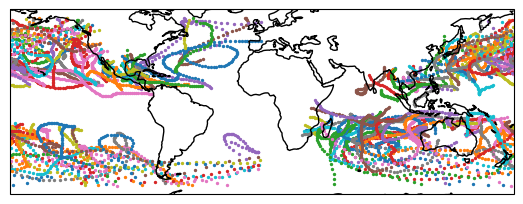

In [16]:
# Plot the last realization of syntheric TC tracks (one year):

## probably don't need to import these twice
import matplotlib.pyplot as plt
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature

MyFigsize,MyFontsize = (6.5,4),8
londis, latdis = 30, 15
lon1, lon2 = 10,350
lat1, lat2 = -60, 60
my_proj = ccrs.PlateCarree(central_longitude=180)
data_ccrs = ccrs.PlateCarree()

fig = plt.figure(figsize=MyFigsize)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(zorder=100)

for i, longen in enumerate(climInitLon):
    lat, lon = fst['lat'][:, i], fst['lon'][:, i]
    plt.scatter(lon, lat, s=2, transform=ccrs.PlateCarree())


## Step 3: Mean and Standard deviation of all the predictors
To calculate the mean and standard deviation of the predictors, we need to apply observed tracks over model fields for the period of 1980-2012 using getMeanStd.py. It is a single stand-alone script, so we are not running it here but providing you with the output: result_w.nc and results_l.nc.

## Step 4: Intensity

Using tracks and predictors calculated from Step 2, and predictors' mean and standard deviation from 'getMeanStd.py', we are now calculate storm intensity

In [17]:
### fully vectorized from original
def get_E1(bt):
    """
    get errors and residual of errors from predictand bt
    return:
      errors(E1), 
      [v0E],
      ranges of v0 (cat1)
    """

    ## TODO: maybe change data, data1, data4, names to 
    ## something more meaningful

    NS = np.where((bt['StormYear']>=1981)&(bt['StormYear']<=2012))[0]

    data  = bt['errors'][:, NS].values          # shape (T, N)
    data2 = bt['StormMwspd'][:, NS].values      # shape (T, N)

    # flatten everything
    ## 'F' denotes 'column-major' (or 'fortran style') 
    ## rather than 'row-major'
    data1 = data.ravel(order = 'F')
    data4 = data2.ravel(order = 'F')

    ## mask out NaNs in data1
    nan_mask = ~np.isnan(data1)

    E1  = data1[nan_mask]
    E0  = data1[nan_mask]      
    v0E = data4[nan_mask]

    E2 = E0 * E1 * v0E
    mask = (E2 == E2)
    E0 = E0[mask]
    E1 = E1[mask]
    v0E = v0E[mask]
    c11, c0 = np.polyfit(E0, E1, 1)

    vals = v0E
    vmin = vals.min()
    vmax = vals.max()

    ## threshold grids 
    grid_up = np.arange(vmin, vmax, 10)       # for c1 (min → max)
    grid_dn = np.arange(vmax, vmin, -10)      # for c2 (max → min)

    ### c1 
    ## for every threshold iC in grid_up, compute how many values satisfy v0E < iC
    ## (n_vals,1) < (1,n_thresholds)
    counts_lt = (vals[:, None] < grid_up[None, :]).sum(axis=0)

    ## Pick first threshold where count > 50
    idx = np.argmax(counts_lt > 50) if np.any(counts_lt > 50) else len(grid_up)-1
    c1 = grid_up[idx]

    ### c2 
    # for every threshold iC in grid_dn, compute how many values satisfy v0E > iC
    counts_gt = (vals[:, None] > grid_dn[None, :]).sum(axis=0)

    idx = np.argmax(counts_gt > 50) if np.any(counts_gt > 50) else len(grid_dn)-1
    c2 = grid_dn[idx]

    ## final range
    cat1 = np.arange(c1, c2 + 10, 10)

    return E0,v0E,cat1

def findError(errort, v0E, v0, cat1):
    '''
    Calculate error 
    Reduces if statement trees. 
    '''
    if np.isnan(v0):
        return 0
    
    # Find the bin once using searchsorted (faster than find_range)
    if v0 <= cat1[0]:
        mask = v0E < cat1[1]
    elif v0 >= cat1[-1]:
        mask = v0E >= cat1[-1]
    else:
        ## Use searchsorted instead of find_range - it's faster
        j0 = np.searchsorted(cat1, v0, side='right') - 1
        mask = (v0E >= cat1[j0]) & (v0E < cat1[j0+1])
    
    error1 = errort[mask]
    return rng.choice(error1)


from bisect import bisect_left, bisect_right

def find_range(array, a):
    """
    Return two indices in which a is in between in an array
    array has to be a monotonic increase or decrease array
    """
    if (np.diff(array)<0).any():
        start = bisect_right(array[::-1],a)
        end = bisect_left(array[::-1],a)
        end = array.shape[0]-start
        start = end
    else:
        start = bisect_right(array,a)
        end = bisect_left(array,a)
    return (start-1, end)


# def getPrediction_v0input_result(bt,meanX,meanY,stdX,stdY,it,
#                                  index,fstperiod,result,predictors,
#                                  TimeDepends,v0,dvdt):
#       ## original-ish
#     v1 = []
#     h1 = []
#     v1.append(v0)
#     h1.append(bt.Time[it,index])

#     for ih in fstperiod:
#         h1.append(bt.Time[it,index]+timedelta(hours = ih))
#         lT = int(ih/6)
#         dy = result[0]#.params[0]
#         count2 = 0
#         for var in predictors:
#             #print meanX.shape
#             ## tried to replace with dictionary, not sure if using all of these 
#             if var in 'SHRD':
#                 rvar =nanmean(np.sqrt(bt.UShearMean[it:it+lT+1,index]**2+bt.VShearMean[it:it+lT+1,index]**2))
#             elif var in 'dPIwspd':
#                 rvar = nanmean(bt.PIwspdMean[it:it+lT+1,index])-v0
#             elif var in TimeDepends:
#                 rvar = nanmean(getattr(bt,var)[it:it+lT+1,index])
#             elif var in 'StormMwspd':
#                 rvar = v0
#             elif var in 'dVdt':
#                 rvar = dvdt
#             elif var in 'landmaskMean':
#                 rvar = getattr(bt,var)[it+lT+1,index]-getattr(bt,var)[it,index]
#             elif var in 'StormMwspd2':
#                 rvar = (getattr(bt,'StormMwspd')[it,index])**2
#             elif var in 'StormMwspd3':
#                 rvar = (getattr(bt,'StormMwspd')[it,index])**3
#             elif var in 'MPI':
#                 rvar = nanmean(bt.PIwspdMean[it:it+lT+1,index])
#             elif var in 'MPI2':
#                 rvar = nanmean(bt.PIwspdMean[it:it+lT+1,index])**2
#             elif var in 'dPIwspd2':
#                 rvar = (nanmean(bt.PIwspdMean[it:it+lT+1,index])-v0)**2
#             elif var in 'dPIwspd3':
#                 rvar = (nanmean(bt.PIwspdMean[it:it+lT+1,index])-v0)**3
#             elif 'dVdt2' in var:
#                 rvar = dvdt**2
#             elif 'dVdt3' in var:
#                 rvar = dvdt**3
#             else:
#                 rvar = getattr(bt,var)[it,index]

#             #print(var, rvar)
            
#             rvar = (rvar-meanX[count2+1])/stdX[count2+1]
#             dy = dy + rvar*result[count2+1]
#             count2 = count2 + 1
#         dy = (dy*stdY)+meanY
#         v1.append(v0+dy)
#     return h1,v1


## trying to numba speedup getPrediction
# ## doesn't improve efficiency very much, but doesn't slow it down, still tinkering

@numba.jit(nopython=True, cache=True)
def _compute_shrd(UShear, VShear):
    """Compute shear magnitude"""
    return np.sqrt(UShear**2 + VShear**2)

@numba.jit(nopython=True, cache=True)
def _normalize_and_accumulate(rvar, meanX_val, stdX_val, result_val, dy):
    """Normalize variable and add to accumulator"""
    rvar_norm = (rvar - meanX_val) / stdX_val
    return dy + rvar_norm * result_val

def getPrediction_v0input_result(bt,meanX,meanY,stdX,stdY,it,
                                 index,fstperiod,result,predictors,
                                 TimeDepends,v0,dvdt):
    v1 = []
    h1 = []
    v1.append(v0)
    h1.append(bt.Time[it,index])
    
    for ih in fstperiod:
        h1.append(bt.Time[it,index]+timedelta(hours = ih))
        lT = int(ih/6)
        dy = result[0]
        count2 = 0
        
        ## reduces number of nanmean calls slightly 
        piwspd_mean = nanmean(bt.PIwspdMean[it:it+lT+1,index])

        for var in predictors:
            #print meanX.shape
            ## change to == instead of 'in' for robustness
            if var == 'SHRD':
                ## use numba optimized function for SHRD calculation
                ushear = bt.UShearMean[it:it+lT+1,index]
                vshear = bt.VShearMean[it:it+lT+1,index]
                rvar = nanmean(_compute_shrd(ushear, vshear))
                #rvar = _nanmean(_compute_shrd(ushear, vshear))
            elif var == 'dPIwspd':
                #rvar = nanmean(bt.PIwspdMean[it:it+lT+1,index])-v0
                #rvar = _nanmean(bt.PIwspdMean[it:it+lT+1,index])-v0
                rvar = piwspd_mean-v0
            elif var in TimeDepends:
                rvar = nanmean(getattr(bt,var)[it:it+lT+1,index])
                #rvar = _nanmean(getattr(bt,var)[it:it+lT+1,index])
            elif var == 'StormMwspd':
                rvar = v0
            elif var == 'dVdt':
                rvar = dvdt
            elif var == 'landmaskMean':
                rvar = getattr(bt,var)[it+lT+1,index]-getattr(bt,var)[it,index]
            elif var == 'StormMwspd2':
                rvar = (getattr(bt,'StormMwspd')[it,index])**2
            elif var == 'StormMwspd3':
                rvar = (getattr(bt,'StormMwspd')[it,index])**3
            elif var == 'MPI':
                rvar = piwspd_mean
            elif var == 'MPI2':
                rvar = piwspd_mean**2
            elif var == 'dPIwspd2':
                rvar = (piwspd_mean-v0)**2
            elif var == 'dPIwspd3':
                rvar = (piwspd_mean-v0)**3
            elif var == 'dVdt2':
                rvar = dvdt**2
            elif var == 'dVdt3':
                rvar = dvdt**3
            else:
                rvar = getattr(bt,var)[it,index]

            # ## Normalize and accumulate
            # rvar = (rvar-meanX[count2+1])/stdX[count2+1]
            # dy = dy + rvar*result[count2+1]
            # count2 = count2 + 1

            ## normalize and accumulate using numba
            dy = _normalize_and_accumulate(rvar, meanX[count2+1], 
                                           stdX[count2+1], 
                                           result[count2+1], dy)
            count2 = count2 + 1
            
        dy = (dy*stdY)+meanY
        v1.append(v0+dy)
    return h1,v1

def get_landmask_value(bt, it, lT, iS):
    '''
    created this to remove duplicate code in get_determin and get_stochastic
    '''
    ## removed copy.copy -- these are numpy arrays, so shouldn't overwrite in place?
    ## but double check for robustness

    # using a single lookup instead of two
    ## slightly faster without optimized dask
    ## not sure about all edge cases 
    landmask_it = bt.landmaskMean[it,iS]
    landmask_itlT = bt.landmaskMean[it+lT,iS]
    
    # further simplifying boolean logic
    if landmask_itlT <= -0.5 and landmask_it <= -0.5:
        return result_w, meanX_w, meanY_w, stdX_w, stdY_w, \
               ['StormMwspd','dVdt','trSpeed','dPIwspd','SHRD','rhMean','dPIwspd2','dPIwspd3','dVdt2']
    
    ## assuming no other combination available except
    ## landmask_itlT > -0.5 and landmask_it > -0.5
    else:
        return result_l, meanX_l, meanY_l, stdX_l, stdY_l, \
               ['StormMwspd','dVdt','trSpeed','dPIwspd','SHRD','rhMean','dPIwspd2','dPIwspd3','dVdt2','landmaskMean']


def get_determin(iiS, block_id=None):
    '''
    This function finds the deterministic component of the autoregressive TC intensity model.
    iiS: bt data for intensity model

    '''
    iS = np.int_(iiS.mean(keepdims=True))
    
    lT = 2
    
    ## Pre-extract this storm's data once
    ## doesn't save that much time, but a little more read-able
    StormLon_iS = bt.StormLon[:,iS]
    StormLat_iS = bt.StormLat[:,iS]
    landmaskMean_iS = bt.landmaskMean[:,iS]
    
    dummy = StormLon_iS[StormLon_iS==StormLon_iS]
    TimeDepends = ['dThetaEsMean','T200Mean','rhMean','rh500_300Mean','div200Mean']
    
    if ((dummy.any()) and (np.abs(StormLat_iS[0])>=5.)):
        it1 = 0
        it2 = np.int_(np.min([np.argwhere(StormLon_iS==dummy[-1])[-1,0],bt.StormLon.shape[0]-5]))
        
        if ((StormLat_iS[0] >=0) and (bt.StormLon[0,iS]>=120) and (bt.StormLon[0,iS]<=180)):
            bt.determin[0,iS] = np.max([20, rng.choice(intV[intV==intV])])
        else:
            bt.determin[0,iS] = np.max([25, rng.choice(intV[intV==intV])])
        
        dvdt = 0.0
        ih = 12
        lT = np.int_(ih/6)
        v0 = bt.determin[0,iS]
        
        ## can't really vectorize this
        ## but did make the if statements slightly more legible
        for it in range(it1,it2+2,2):
            if (
                it + lT < bt.StormLon.shape[0]
                and not np.isnan(StormLon_iS[it])
                and not np.isnan(landmaskMean_iS[it])
                and not np.isnan(landmaskMean_iS[it + lT])
                and not np.isnan(v0)
            ):
                ## code was identical between get_determin and get_stochastic, 
                ## defined a new function 
                ## may also help with landmask adjustment later
                result, meanX, meanY, stdX, stdY, predictors = get_landmask_value(bt, it, lT, iS)
                
                h1,v1 = getPrediction_v0input_result\
                         (bt,meanX,meanY,stdX,stdY,it,\
                         iS,[ih],result,predictors,\
                         TimeDepends,v0,dvdt)
                
                v1 = v1[1]
                if v1 < 10:
                    v1 = np.float64('Nan')
                    break
                bt.determin[it+lT,iS] = v1
                if ((bt.determin[it1:it+lT:lT,iS].max()>35) and (bt.determin[it,iS]<=35) and (bt.determin[it-lT,iS]<=35)):
                    break
                dvdt = v1-v0
                v0 = v1

        ## original
        # for iit in range(it1+1,np.min([it2+1,bt.StormLon.shape[0]-2]),2):
        #     a = bt.determin[iit-1,iS]*bt.determin[iit+1,iS]
        #     if a==a:
        #         bt.determin[iit,iS] = \
        #         0.5*(bt.determin[iit-1,iS]+bt.determin[iit+1,iS])
        ## vectorized
        ## basically same vectorization pattern as get_stochastic
        iit_indices = np.arange(it1+1, min(it2+1, bt.StormLon.shape[0]-2), 2)
        prev_vals = bt.determin[iit_indices-1, iS]
        next_vals = bt.determin[iit_indices+1, iS]

        mask = ~np.isnan(prev_vals * next_vals)  # true where neither is NaN

        bt.determin[iit_indices[mask], iS] = 0.5 * (prev_vals[mask] + next_vals[mask])
    
    return iS

def get_stochastic(iiS,block_id=None):
    '''
    This function finds the stochastic component of the autoregressive TC intensity model.
    iiS: bt data for intensity model
    '''
    TimeDepends = ['dThetaEsMean','T200Mean','rhMean','rh500_300Mean','div200Mean']
    iS = np.int_(iiS.mean(keepdims=True))
    dummy = bt.StormLon[:,iS][bt.StormLon[:,iS]==bt.StormLon[:,iS]]
    if ((dummy.any()) and (np.abs(bt.StormLat[0,iS])>=5.)):
        it1 = 0
        it2 = np.min([np.argwhere(bt.StormLon[:,iS]==dummy[-1])[-1,0],bt.StormLon.shape[0]-5])
        
        if ((bt.StormLat[0,iS] >=0) and (bt.StormLon[0,iS]>=120) and (bt.StormLon[0,iS]<=180)):
            ## update to use set rng
            ##bt.stochastic[0,iS,iNN] = np.max([20,random.choice(intV[intV==intV])]) # kts
            bt.stochastic[0, iS, iNN] = np.max([20, rng.choice(intV[intV==intV])]) #kts
        else:
            ##bt.stochastic[0,iS,iNN] = np.max([25,random.choice(intV[intV==intV])]) # kts
            bt.stochastic[0, iS, iNN] = np.max([25, rng.choice(intV[intV==intV])]) #kts
        ih = 12
        lT = np.int_(ih/6)
        v0 = bt.stochastic[0, iS, iNN]
        dvdt = 0.
        for it in range(it1,it2+2,2):
            # if ((it+lT<bt.StormLon.shape[0]) and (bt.StormLon[it,iS]==bt.StormLon[it,iS])\
            #         and (bt.landmaskMean[it,iS]==bt.landmaskMean[it,iS]) \
            #         and (bt.landmaskMean[it+lT,iS]==bt.landmaskMean[it+lT,iS]) and not np.isnan(v0)):

            ## making if statement a bit more readable
            if (
                it + lT < bt.StormLon.shape[0]
                and not np.isnan(bt.StormLon[it, iS])
                and not np.isnan(bt.landmaskMean[it, iS])
                and not np.isnan(bt.landmaskMean[it + lT, iS])
                and not np.isnan(v0)
            ):
                
                result, meanX, meanY, stdX, stdY, predictors = get_landmask_value(bt, it, lT, iS)
   
                h1,v1 = getPrediction_v0input_result\
                     (bt,meanX,meanY,stdX,stdY,it,\
                     iS,[ih],result,predictors,\
                     TimeDepends,v0,dvdt)
                
                error = findError(E0,v0E,v0,cat1)
                bt.error[it,iS,iNN] = error
                v1 = v1[1]
                v1 = v1-error
                if v1 < 10:
                    break;
                
                #if ((it >= it1+4*lT) and (bt.stochastic[it,iS,iNN]<=35) and (bt.stochastic[it-lT,iS,iNN]<=35)):
                bt.stochastic[it+lT,iS,iNN] = v1
                
                if ((bt.stochastic[it1:it+lT:lT,iS,iNN].max()>35) and (bt.stochastic[it,iS,iNN]<=35) and (bt.stochastic[it-lT,iS,iNN]<=35)):
                    break;
                dvdt = v1-v0
                v0 = v1

        ## original
        # for iit in range(it1+1,np.min([it2+1,bt.StormLon.shape[0]-2]),2):
        #     a = bt.stochastic[iit-1,iS,iNN]*bt.stochastic[iit+1,iS,iNN]
        #     if a==a:
        #         bt.stochastic[iit,iS,iNN] = \
        #             0.5*(bt.stochastic[iit-1,iS,iNN]+bt.stochastic[iit+1,iS,iNN])
                
        ## vectorized
        # iit indices (every 2 steps)
        iit_indices = np.arange(it1+1, min(it2+1, bt.StormLon.shape[0]-2), 2)
        # neighbor values
        prev_vals = bt.stochastic[iit_indices - 1, iS, iNN]
        next_vals = bt.stochastic[iit_indices + 1, iS, iNN]
        # mask where neither neighbor is NaN
        mask = ~np.isnan(prev_vals * next_vals)
        # assign averaged values where valid
        bt.stochastic[iit_indices[mask], iS, iNN] = 0.5 * (prev_vals[mask] + next_vals[mask])

    return iS

def load_nc_via_pooch(filename):
    """Load NetCDF file via pooch and return xarray Dataset."""
    path = pooch.retrieve(url=f"{path_data}/{filename}", known_hash=None)
    return xr.open_dataset(path)


def calIntensity(iy, ichaz):
    '''
    This function calculates the intesity using an autoregressive model (Lee et al. (2015, 2016a)).
    EXP: location of historical simulations defined in Namelist.py
    iy: year of current iteration in CHAZ.py
    ichaz: current ensemble iteration in CHAZ.py`
    '''

    ## load datasets 
    bt2 = load_nc_via_pooch(gv.obpath)
    observed_data_ds = load_nc_via_pooch("observed_data.nc")
    coefficient_meanstd_ds = load_nc_via_pooch("coefficient_meanstd.nc")
    result_w_ds = load_nc_via_pooch("result_w.nc")
    result_l_ds = load_nc_via_pooch("result_l.nc")

    global result_w, result_l, meanX_w, meanY_w, stdX_w
    global stdY_w, meanX_l, meanY_l, stdX_l, stdY_l
    global E0, v0E, cat1, intV

    ## convert all variables into numpy arrays 
    result_w = result_w_ds['params'].values
    result_l = result_l_ds['params'].values
    meanX_w = coefficient_meanstd_ds.meanX_w.values
    meanY_w = coefficient_meanstd_ds.meanY_w.values
    stdX_w  = coefficient_meanstd_ds.stdX_w.values
    stdY_w  = coefficient_meanstd_ds.stdY_w.values
    meanX_l = coefficient_meanstd_ds.meanX_l.values
    meanY_l = coefficient_meanstd_ds.meanY_l.values
    stdX_l  = coefficient_meanstd_ds.stdX_l.values
    stdY_l  = coefficient_meanstd_ds.stdY_l.values

    ## TODO change variable name to not overwrite NS below
    NS = np.where((bt2['StormYear']>=1981)&(bt2['StormYear']<=2012))[0]
    intV = bt2['StormMwspd'][:][0,NS].values
    E0, v0E,cat1, = get_E1(bt2)

    ## initialize bt
    nsto = gv.CHAZ_Int_ENS
    bt.__dict__['determin'] = np.zeros(bt.StormLon.shape)*np.float64('nan')
    bt.__dict__['stochastic'] = np.zeros([bt.StormLon.shape[0],bt.StormLon.shape[1],nsto])*np.float64('nan')
    bt.__dict__['error'] = np.zeros([bt.StormLon.shape[0],bt.StormLon.shape[1],nsto])*np.float64('nan')

    ## TODO change variable name to not overwrite NS above
    NS = np.arange(0,bt.StormYear.shape[0],1)
    nS = da.from_array(NS.astype(dtype=np.int32),chunks=(1,))

    ## removed progress bars -- big overhead
    new = da.map_blocks(get_determin,nS,chunks=(1,), dtype=nS.dtype)
    ## removed progressbar
    n = new.compute(scheduler='synchronous',num_workers=10)
    #n = new.compute(scheduler='single-threaded',num_workers=10)
    del new
    #gc.collect()

    ## removed progress bars -- big overhead
    new =da.map_blocks(get_stochastic,nS,chunks=(1,), dtype=nS.dtype)
    global iNN
    for iNN in range(nsto):
        n = new.compute(scheduler='synchronous',num_workers=10)
        #n = new.compute(scheduler='single-threaded')
        #gc.collect()
    del new

    gc.collect()

    return bt

In [18]:
import cProfile
import pstats
from pstats import SortKey

## profiler
def profile_calIntensity(iy, ichaz):
    '''
    Profile calIntensity to find bottlenecks
    '''
    profiler = cProfile.Profile()
    profiler.enable()
    
    # Run the original function
    result = calIntensity(iy, ichaz)
    
    profiler.disable()
    
    # Print stats
    stats = pstats.Stats(profiler)
    stats.strip_dirs()
    stats.sort_stats(SortKey.CUMULATIVE)
    
    print("\n" + "="*80)
    print("TOP 30 FUNCTIONS BY CUMULATIVE TIME")
    print("="*80)
    stats.print_stats(30)
    
    print("\n" + "="*80)
    print("TOP 30 FUNCTIONS BY TIME PER CALL")
    print("="*80)
    stats.sort_stats(SortKey.TIME)
    stats.print_stats(30)
    
    return result

#tc_downscaled = profile_calIntensity(yearTC, gv.CHAZ_ENS)

In [19]:
%%time
tc_downscaled = calIntensity(yearTC, gv.CHAZ_ENS)


/var/folders/72/gq_qh34d21xgnsw2_5sf25rh0000gn/T/ipykernel_88303/811393314.py:228: RuntimeWarning: overflow encountered in square
  rvar = (piwspd_mean-v0)**2
/var/folders/72/gq_qh34d21xgnsw2_5sf25rh0000gn/T/ipykernel_88303/811393314.py:230: RuntimeWarning: overflow encountered in power
  rvar = (piwspd_mean-v0)**3
/var/folders/72/gq_qh34d21xgnsw2_5sf25rh0000gn/T/ipykernel_88303/811393314.py:232: RuntimeWarning: overflow encountered in square
  rvar = dvdt**2
/var/folders/72/gq_qh34d21xgnsw2_5sf25rh0000gn/T/ipykernel_88303/811393314.py:432: RuntimeWarning: overflow encountered in multiply
  mask = ~np.isnan(prev_vals * next_vals)


CPU times: user 20.9 s, sys: 2.02 s, total: 22.9 s
Wall time: 23.2 s


### Speedups
current WALL times best times:
- `calIntensity`: 25.9 s
    - with land_mask optimization (which is slower with dask optimizing)
    - goes down to 25.6 with get_determin improvements
    - re-optimizing findErrror 25.4
    - letting python handle gc.collect() -- not calling inside loop: 23.3s (could probably remove entirely)
    - reduce nanmean calls (slightly) by cacheing `piwspd_mean = nanmean(bt.PIwspdMean[it:it+lT+1,index])` in `getPrediction_v0input_result`: 22.1s
- `calIntensity_better_dask`: 26 s

original: 38.5 s

In [20]:
#cProfile.run('tc_downscaled = calIntensity(yearTC, gv.CHAZ_ENS)')

## Step 5: Clean up and save to NetCDF format



In [21]:

## tidied this up so it isn't a giant list of basinMap[a==0000]
## TODO double check that all the basinMap code works and matches original 
def getbasinMap(ifplot=False):
    '''
    This function returns x bins, y bins, and a plot of the basin map.
    '''
    xbin = np.arange(0, 365, 5)
    ybin = np.arange(-90, 95, 5)
    xcenter = 0.5 * (xbin[:-1] + xbin[1:])
    ycenter = 0.5 * (ybin[:-1] + ybin[1:])
    
    basinMap = np.zeros((xcenter.size, ycenter.size))
    lonc, latc = np.meshgrid(xcenter, ycenter, indexing='ij')
    
    # define basins using a dictionary 
    basins = {
        1: (lonc >= 235) & (latc >= 0) & (latc <= 45),                 # n_atl
        2: (lonc >= 180) & (lonc < 235) & (latc >= 0) & (latc <= 45),  # n_enp
        3: (lonc >= 100) & (lonc < 180) & (latc >= 0) & (latc <= 45),  # n_wnp
        4: (lonc < 100) & (latc >= 0) & (latc <= 45),                  # n_ni
        5: (lonc < 90) & (latc < 0) & (latc >= -45),                   # n_sin
        6: (lonc >= 90) & (lonc < 160) & (latc < 0) & (latc >= -45),   # n_aus
        7: (lonc >= 160) & (lonc < 240) & (latc < 0) & (latc >= -45)   # n_spc
    }
    
    for basin_id, mask in basins.items():
        basinMap[mask] = basin_id

    # fix specific indices (flattened)
    ## pretty sure i got all of them
    fix_indices = [
        1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719,  
        1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 
        1782, 1783, 1784, 1785, 1786, 1787, 1818, 1819, 1820, 1821, 
        1822, 1823, 1854, 1855, 1856, 1857, 1890, 1891, 1892, 1893, 
        1926, 1927, 1928, 1962, 1963, 1964, 1998, 1999
    ]
    basinMap.ravel()[np.isin(np.arange(basinMap.size), fix_indices)] = 2
    
    return xbin, ybin, basinMap

def defineBasin(lon0_obs,lat0_obs,basinlon,basinlat,basinMap):
    '''
    Defines basin based on observations and knowledge about the basin.
    lon0_obs: initial longitude observed
    lat0_obs: initial latitude observed
    basinlon: basin longitude
    basinlat: basin latitude 
    basinMap: map of basin
    '''
    ### avoid NaN
    basin = np.zeros(lon0_obs.shape)
    ###
    lat0_obs[lat0_obs>=90] = 89.9
    lat0_obs[lat0_obs<=-90] = -89.9
    notNaN_arg = np.where(~np.isnan(lon0_obs*lat0_obs))
    x = np.floor(lon0_obs[notNaN_arg]/np.diff(basinlon)[0])
    y = np.floor((lat0_obs[notNaN_arg]-basinlat[0])/np.diff(basinlat)[0])
    x[x==basinMap.shape[0]] = basinMap.shape[0]-1
    y[y==basinMap.shape[1]] = basinMap.shape[1]-1
    basin[notNaN_arg] = basinMap[np.int_(x),np.int_(y)]
    return(basin)

In [22]:
xbin,ybin,basinMap = getbasinMap()

bt1 = copy.copy(tc_downscaled)

lon0,lat0 = bt1.StormLon[0,:],bt1.StormLat[0,:]
basin = defineBasin(lon0,lat0,xbin,ybin,basinMap)

#### get rid of storms  that has never developed
bt1.stochastic[bt1.stochastic==0] = np.float64('nan')
max5 = np.nanmax(bt1.stochastic[0:21,:,:],axis=0)
iS1 = np.argwhere(max5<35)[:,0]
iN1 = np.argwhere(max5<35)[:,1]
bt1.stochastic[:,iS1,iN1] = np.float64('nan')
maxall = np.nanmax(bt1.stochastic,axis=0)
v0 = bt1.stochastic[0,:,:]
#### get rid of storms that becoming unstable
iS1 = np.argwhere(maxall>300)[:,0]
iN1 = np.argwhere(maxall>300)[:,1]
bt1.stochastic[:,iS1,iN1] = np.float64('nan')
#### get rid of storms that initially formed with 2 degree lon,lat
iS1 = np.argwhere(np.abs(bt1.StormLat[0,:])<2)[:,0]
bt1.stochastic[:,iS1,:] = np.float64('nan')
bt1.StormLon[0,iS1] = np.float64('nan')
iS1 = np.argwhere(basin==0)
bt1.StormLon[0,iS1] = np.float64('nan')

#### get rid of storms that have no intensity record
maxall = np.nanmax(bt1.stochastic,axis=0)
#changed
iS1 = np.argwhere(maxall<=0)[:,0]
iN1 = np.argwhere(maxall<=0)[:,1]
bt1.stochastic[:,iS1,iN1] = np.float64('nan')
#bt1.stochastic[:,basin!=1,:] = np.float('nan')
arg = np.argwhere(bt1.StormLon[0,:] == bt1.StormLon[0,:])[:][:,0]

newlon = bt1.StormLon[:,arg]
newlat = bt1.StormLat[:,arg]
newwspd = bt1.stochastic[:,arg]
newdatenum = bt1.Time[:,arg]
newYear = bt1.StormYear[arg]
newMonth = bt1.StormInitMonth[arg]

#dummy dataframe
ensembleNum = np.arange(newwspd.shape[2])
stormID = np.arange(arg.shape[0])
lifelength = np.arange(newdatenum.shape[0])

ds = xr.Dataset({
  'longitude': xr.DataArray(
  data = newlon,
  dims = ['lifelength','stormID'],
  coords = {'lifelength':lifelength, 'stormID':stormID},
  attrs = {
    '_FillValue': np.float64('nan'),
    'units': 'degrees east'}
  ),
  'latitude': xr.DataArray(
  data = newlat,
  dims = ['lifelength','stormID'],
  coords = {'lifelength':lifelength, 'stormID':stormID},
  attrs = {
      '_FillValue': np.float64('nan'),
      'units'     : 'degrees north'
      }
  ),
  'Mwspd': xr.DataArray(
  data =np.rollaxis(newwspd,2,0),
  dims = ['ensembleNum','lifelength','stormID'],
  coords = {'ensembleNum':ensembleNum,'lifelength':lifelength, 'stormID':stormID},
  attrs = {
      '_FillValue': np.float64('nan'),
      'units'     : 'kt'
      }
  ),
  'year': xr.DataArray(
  data = newYear,
  dims = ['stormID'],
  coords = {'stormID':stormID},
  attrs = {
      'units'     : 'year'
      }
  ),
  'time': xr.DataArray(
  data = date2num(newdatenum, units='days since 1950-01-01 00:00', calendar='standard'),
  dims = ['lifelength','stormID'],
  coords = {'lifelength':lifelength, 'stormID':stormID},
  attrs = {
      'units'     : 'days since 1950-01-01 00:00'
      }
  )
})

file_name = f'{yearTC:04d}_001.nc'
print(file_name)
ds.to_netcdf(file_name)


2017_001.nc


/var/folders/72/gq_qh34d21xgnsw2_5sf25rh0000gn/T/ipykernel_88303/3560152834.py:10: RuntimeWarning: All-NaN slice encountered
  max5 = np.nanmax(bt1.stochastic[0:21,:,:],axis=0)
/var/folders/72/gq_qh34d21xgnsw2_5sf25rh0000gn/T/ipykernel_88303/3560152834.py:14: RuntimeWarning: All-NaN slice encountered
  maxall = np.nanmax(bt1.stochastic,axis=0)
/var/folders/72/gq_qh34d21xgnsw2_5sf25rh0000gn/T/ipykernel_88303/3560152834.py:28: RuntimeWarning: All-NaN slice encountered
  maxall = np.nanmax(bt1.stochastic,axis=0)


# Step 6: Basic Checking

*   Track color-coded with intensity, we use intensity ensemble #0




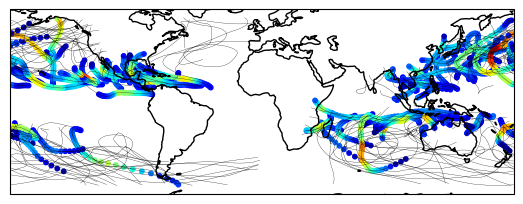

In [23]:
import matplotlib.pyplot as plt
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature

MyFigsize,MyFontsize = (6.5,4),8
londis, latdis = 30, 15
lon1, lon2 = 10,350
lat1, lat2 = -60, 60
my_proj = ccrs.PlateCarree(central_longitude=180)
data_ccrs = ccrs.PlateCarree()

fig = plt.figure(figsize=MyFigsize)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(zorder=100)
lon = ds['longitude'].values
lat = ds['latitude'].values
mwspd = ds['Mwspd'].values
plt.plot(lon,lat,'k-',transform=ccrs.PlateCarree(),linewidth=0.2)
plt.scatter(lon.ravel(),lat.ravel(),s=10,c=mwspd[1,:,:].ravel(),transform=ccrs.PlateCarree(), cmap='jet')
#plt.colorbar()

*   Intensity evoluation of a track #9



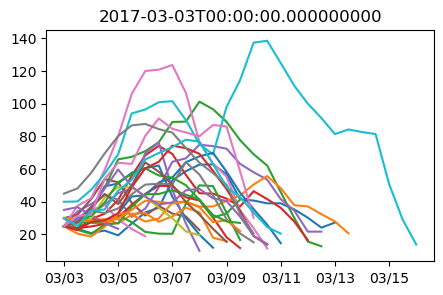

In [24]:
import matplotlib.dates as mdates

fig,ax = plt.subplots(figsize=(5,3))
time_1d = ds.time.values.reshape(-1)
df_chaz_t = pd.to_datetime(time_1d,unit='D',origin=pd.Timestamp('1950-01-01'))
origional_shape = ds.time.values.shape
df_chaz_t = df_chaz_t.to_numpy().reshape(origional_shape)
plt.plot(df_chaz_t[:,22],mwspd[:,:,22].T)
plt.title(df_chaz_t[0,22])
myFmt = mdates.DateFormatter('%m/%d')
ax.xaxis.set_major_formatter(myFmt)



*   Lifetime Maximum Intensity distribution

/var/folders/72/gq_qh34d21xgnsw2_5sf25rh0000gn/T/ipykernel_88303/2662542693.py:1: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(ds['Mwspd'].values,axis=1)


Text(0.5, 1.0, 'LMI')

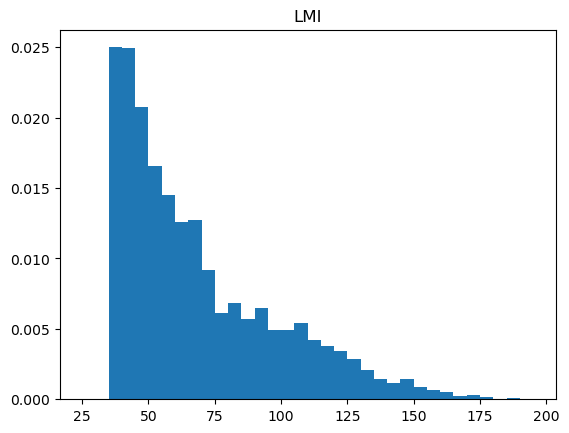

In [25]:
vmax = np.nanmax(ds['Mwspd'].values,axis=1)
plt.hist(vmax.flatten(), bins=np.arange(25,200,5), density=True, )
plt.title('LMI')